# BINA LN2 - Dimitrij Grädel, Kristina Lakic, François Lanzeray, Adina Rodriguez

# 1. Einleitung
In der vorliegenden Arbeit soll aufgearbeitet werden, ob Ankündigung und Inkrafttretung klimabezogener Gesetze eine Auswirkung auf die Aktienkurse von Unternehmen haben.

Eingegrenzt wird dies auf die NASDAQ-kotierten Unternehmen in den USA. Jedem Unternehmen wurde dabei eine Branche zugeordnet.
Die klimabzeogenen Gesetze wurden recherchiert und die Zeitpunkte der Ankündigung und der Inkraftretung ebenfalls zusammengefasst.

Die Daten zu den Unternehmen und den Gesetzen wurden in JSON Objekten gespeichert, diese werden dann automatisiert in die Berechnungen in python einbezogen. Das Vorgehen ist an den jeweiligen Stellen erläutert.

# 2. Technische Vorbereitung
Für den Bezug Aktienkursdaten wird das package "yfinance" (https://pypi.org/project/yfinance/) verwendet. Der erste Codeblock muss daher zwingend immer ausgeführt werden, damit die Daten zu den Aktienkursen abgefragt werden können.

Der erste Codeblock ist definitiv verpflichtend, da er ein benötigtes Verzeichnis erstellt.

In [ ]:
# Create necessary folders (mandatory)

import os

symbolFileDirectory = '/content/symbolData'
symbolFileName = 'verifiedSymbols.json'
symbolFilePath = os.path.join(symbolFileDirectory, symbolFileName)

if not os.path.exists(symbolFileDirectory):
    os.makedirs(symbolFileDirectory)

In [ ]:
# Install required package to download market data from Yahoo! Finance

!pip install yfinance

In [ ]:
# Testblock to ensure yfinance installation was successful
# Expected output: Market data from APPLE INC. for 1st of February 2023 in CSV format

from __future__ import print_function

import sys

import yfinance as yf


def get_symbol_history(symbol, start, end):
    ticker = yf.Ticker(symbol)
    history = ticker.history(start=start, end=end)
    print(history.to_csv())

get_symbol_history('AAPL', '2023-02-01', '2023-02-2')

# 3. Speicherung der Symboldaten
Da die angestrebte Analyse zu einem grossen Teil automatisiert ablaufen soll, werden alle relevanten Unternehmen und ihre Aktiensymbole im Vorfeld aufbereitet. Dies erfolgt über die Auswertung eines Textdokuments, dass per FTP von der Plattform Nasdaq-Trader bezogen wird. Die Inhalte werden dann ausgelesen und im JSON Format abgespeichert.

Es werden nur jene Symbole berücksichtigt, zu denen über die yfinance-Library  eine Information abgefragt werden kann. Da die Anzahl der zugrundeliegenden Daten relevant ist, wurde die Auswahl auf 30 Industrien reduziert (von 140). Es wurden nur Industrien ausgewählt, die mindestens 15 zugehörige Unternehmen haben und die explizit betroffen oder nicht betroffen sein können von klimabezogenen Gesetzgebungen.

In [ ]:
import yfinance as yf
from ftplib import FTP
from io import BytesIO
import os
import json

selectedIndustries = [
    'Biotechnology',
    'Software—Application',
    'Software—Infrastructure',
    'Drug Manufacturers-Specialty & Generic',
    'Asset Management',
    'Diagnostics & Research',
    'Communication Equipment',
    'Semiconductors',
    'Packaged Foods',
    'Information Technology Services',
    'Telecom Services',
    'Electrical Equipment & Parts',
    'Aerospace & Defense',
    'Electronic Components',
    'Credit Services',
    'Auto Manufacturers',
    'Medical Care Facilities',
    'Computer Hardware',
    'Real Estate Services',
    'Specialty Industrial Machinery',
    'Auto Parts',
    'Semiconductor Equipment & Materials',
    'Electronic Gaming & Multimedia',
    'Scientific & Technical Instruments',
    'Engineering & Construction',
    'Solar',
    'Marine Shipping',
    'Farm Products',
    'Oil & Gas E&P',
    'Auto & Truck Dealerships',
]

# only download symbol data if not already downloaded
created = False
if not os.path.isfile(symbolFilePath):
    # create a connection to Nasdaq FTP server to retrieve symbols
    host = 'ftp.nasdaqtrader.com'
    ftpPath = 'SymbolDirectory'
    symbolFile = 'nasdaqlisted.txt'

    reader = BytesIO()

    # read symbols from FTP server file
    ftp = FTP(host)
    ftp.login()
    ftp.cwd(ftpPath)
    ftp.retrbinary('RETR ' + symbolFile, reader.write)


    # verify smybols (only queryable and not a shell company)
    verifiedSymbols = []
    symbols = reader.getvalue().decode('ascii').split('\r\n')[1:-2]
    counter = 0;
    for index, symbolInfo in enumerate(symbols):
        ## Following to lines are used for testing
        #if len(verifiedSymbols) > 19:
        #    break
        symbolArr = symbolInfo.split('|')
        if len(symbolArr) > 1:
            try:
                info = yf.Ticker(symbolArr[0]).info
                if info['industry'] in selectedIndustries:
                    verifiedSymbols.append({
                        'symbol': symbolArr[0],
                        'company': symbolArr[1],
                        'industry': info['industry']
                    })
                    print('Verified ' + symbolArr[0])
                else:
                    print('Ignored ' + symbolArr[0] + ' - industry not qualified')
            except Exception as e:
                print(symbolArr[0] + " was ignored, malformed data")
            continue

    # save the verified symbols to a json file
    with open(symbolFilePath, "w") as file:
        file.write(json.dumps(verifiedSymbols))
        file.close()

    created = True

# Log if file was created or already existed
if created:
    print(f'Verified {len(verifiedSymbols)} symbols. Created new file at {symbolFilePath}')
else:
    print(f'Symbols already downloaded at: {symbolFilePath}')

# 4. Vorstellung der Gesetze
**Clean Power Plan 2015, 03.08.2025**<br>
Der Clean Power Plan war eine Initiative der US-Regierung, die am 03. August 2015 vorgestellt wurde. Das Ziel des Plans bestand darin, den Ausstoss von Treibhausgasen, insbesondere von Kohlendioxid, durch Kraftwerke zu reduzieren und die Energieerzeugung sauberer und klimafreundlicher zu gestalten, sodass die Klimakrise langfristig bekämpft werden kann. Der Clean Power Plan sah vor, dass jeder US-Bundesstaat individuelle Emissionsziele festlegt und Massnahmen ergreift, um diese Ziele zu erreichen. Die Bundesstaaten hatten die Möglichkeit, verschiedene Ansätze zu wählen und selber mit Emissionsrechten zu handeln, um den CO2-Ausstoss zu reduzieren. Durch saubere Energiequellen werden auch Luftschadstoffe reduziert, welche sich positiv auf die öffentliche Gesundheit auswirken. Die Ziele sollten bis 2030 erreicht werden.

Der Plan wurde jedoch von verschiedenen Bundestaaten und Industrieverbänden vor Gericht angefochten und letztendlich nicht vollständig umgesetzt. Im Jahr 2019 hat die Trump-Regierung den Clean Power Plan offiziell zurückgezogen und durch die Affordable Clean Energy (ACE) Rule ersetzt, die weniger strenge Vorschriften für die Kraftwerksemissionen vorsah.

-	Energiezeugungsbranche, Kraftwerke
-	Energiesektor

<br>

**Affordable Clean Energy (ACE) Plan, 21.08.2018**<br>
Der Affordable Clean Energy (ACE) Plan war eine Initiative der US-Regierung unter Präsident Donald Trump, die im Jahr 2019 eingeführt wurde, als Ersatz für den zuvor vorgestellten Clean Power Plan. Im Gegensatz zum Clean Power Plan, der spezifische Emissionsziele für Kraftwerke festlegte, konzentrierte sich der ACE-Plan hauptsächlich auf die Verbesserung der Energieeffizienz von Kohlekraftwerken. Er ermutigte die Kraftwerksbetreiber, Technologien und Massnahmen zu implementieren, die den CO2-Ausstoss pro erzeugter Energieeinheit reduzieren sollten. Die einzelnen Bundesstaaten hatten dadurch mehr Spielraum und waren flexibler bei der Festlegung ihrer eigenen Emissionsstandards und Strategien zu Reduzierung der Kohlendioxidemissionen. Er legte weniger strenge Vorschriften für die Emissionsreduzierung fest als der Clean Power Plan und erlaubte den Bundesstaaten, ihre eigenen Energiepläne zu entwickeln, um den Umweltschutzzielen gerecht zu werden.

<br>

**Paris Climate Agreement, 20.01.2021**<br>
Das Pariser Klimaabkommen ist ein internationales Abkommen, das 2015 von fast allen Ländern der Welt unterzeichnet wurde. Beim Pariser Klimaabkommen geht es darum, dass die involvierten Länder gemeinsam darauf abzielen den Klimawandel zu bekämpfen und die globale Erwärmung unter 2 Grad Celsius zu begrenzen. Im Rahmen des Abkommens verpflichten sich die teilnehmenden Länder, ihre Treibhausgasemissionen zu reduzieren und nationale Klimaschutzpläne, sogenannte Nationally Determined Contributions (NDCs) vorzulegen. Diese Klimaschutzpläne enthalten spezifische Ziele und Massnahmen, die jedes Land ergreifen will, um zur Emissionsreduzierung beizutragen.
Das Pariser Abkommen betont auch die Notwendigkeit der Unterstützung von Entwicklungsländern, sowohl finanziell als auch technologisch, um ihre Klimaschutz- und Anpassungsmassnahmen umzusetzen.

Um das Ziel erreichen zu können, könnte der Ausbau von erneuerbaren Energien verstärkt und der Gebrauch von fossilen Brennstoffen vermindert werden. Auch könnte das Transportwesen davon betroffen werden, da die Nachfrage zu emissionsfreien Fahrzeugen und öffentlichen Verkehrsmitteln steigen könnte. Um das Ziel erreichen zu können, muss die Energieeffizienz von Gebäuden verbessert werden und die Landwirtschat nachhaltiger gestaltet werden. Zusätzlich werden mehr nachhaltige Innovationen finanziert, weshalb der Finanzsektor auch von diesem Abkommen betroffen sein wird.

Ein wichtiges Merkmal des Abkommens ist seine flexiblen Mechanismen, die den Ländern ermöglichen, ihre Ziele anzupassen und sich an veränderte Umstände anzupassen. Es sieht auch regelmässige Überprüfungen und Berichterstattung vor, um den Fortschritt der Länder bei der Umsetzung ihrer Klimaschutzmassnahme zu überwachen.

-	Energieerzeugungsbranche
-	Bau- und Baugewerbe
-	Transportwesen
-	Landwirtschaft
-	Finanzsektor

<br>

**Inflation Reduction Act, 16.08.2022**<br>
Beim Inflation Reduction Act geht es darum, dass die USA darauf abzielt globaler Markführer in sauberer Energie, Produktion Innovation und Technologie zu werden. Dies mit einer Investition von 370 Millionen US-Dollar, welche dazu führen sollte, dass saubere Energiesystem vorangetrieben werden und die Energiekosten für Familien und Unternehmen gesenkt werden.

Es wird in den Ausbau von Elektroinfrastruktur, Modernisierung des Stromnetzes, , vermehrte Möglichkeiten für Ladestation von Elektrofahrzeugen sowie Ausbau des Öffentlichen Verkehrs investiert. Dies in dem der Inflatation Reduction Act auf den Bibartisan Infratstructure Law aufbaut. Dadurch wird es zu neuen Arbeitsplätzen kommen welche vor allem auch gute Arbeitsplätze mit angemessenem Lohn und Zusatzleistungen mit sich bringen werden.

Es sollen auch Umweltgerechtigkeiten und benachteiligte Minderheiten gefördert werden. Dies in dem Vorteile, welche aus den Klimaschutzmassnahmen und der sauberen Energie gewonnen werden, in marginalisierte Gemeinschaften angesiedelt werden. Auswirkungen von Umweltverschmutzungen in diesen Gemeinschaften werden so verringert und die Umweltbedingungen verbessert.


-	Erneuerbare Energie
-	Enegeriespeicherung
-	Elektrofahrzeuge
-	Energieefizienz
-	Solar- Windkraftanlagen
-	Bau / Energieversorgung
-	Elektromobilität / Transport
-	Wissenschaft / Technologie / Chemie / Stahl



# 5. Ermittlung der Gesetzesauswirkungen
Um die Auswirkung der Gesetze festzustellen, werden die 30 Tage nach dem Inkraftreten der Gesetze untersucht. Dazu wird der Korrelationskoeffizient jedes Aktienkurses in dieser Zeit berechnet und gespeichert.
Die Ergebnisse davon werden in einem neuen JSON File (verifiedSymbolsWithCors.json) gespeichert. Da ein Download aller Daten recht lange dauert, kann auch hier auf ein vorab erstelltes File zurückgegriffen werden. Der Code fragt von sich aus ab, ob ein entsprechendes File bereits existiert. Es wird empfohlen ein bestehendes File nur umzubenennen, nicht zu löschen.

In [ ]:
from sqlalchemy.pool.impl import FallbackAsyncAdaptedQueuePool
import yfinance as yf
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
import matplotlib.dates as mdates
import sys
from datetime import datetime, timedelta
from scipy.stats import linregress

symbolWithCorsFileName = 'verifiedSymbolsWithCors.json'
symbolWithCorsFilePath = os.path.join(symbolFileDirectory, symbolWithCorsFileName)

# only download symbol data if not already downloaded
created = False
if not os.path.isfile(symbolWithCorsFilePath):
    ### 5.1 Defining an object for the different laws
    laws = [
        {'code': 'CPP', 'name': 'Clean Power Plan', 'date': '2015-08-03'},
        {'code': 'ACE', 'name': 'Affordable Clean Energy ', 'date': '2018-08-21'},
        {'code': 'PCA', 'name': 'Paris Climate Agreement ', 'date': '2021-01-20'},
        {'code': 'IRA', 'name': 'Inflation Reduction Act ', 'date': '2022-08-16'}
    ]

    ### 5.2 Using the saved symbols to query the month after the laws came into effect
    with open(symbolFilePath, "r") as file:
        symbols = json.load(file)

    ## 5.2.1 Calculating the cor
    # function to get the cor
    def calculateCor(symbol, startDate):
        # define start and end date
        startDate = datetime.strptime(startDate, '%Y-%m-%d')
        endDate = startDate + timedelta(days=30)

        # get data for symbol, only use closing value / return False if period is not queryable
        try:
            data = yf.download(symbol, start=startDate, end=endDate, progress=False, show_errors=False)
            closePrices = data['Close']
            dates = closePrices.index

            # calculate trend line
            days = [date.day for date in dates]
            slope, intercept, rValue, pValue, stdErr = linregress(days, closePrices)

            # return cor of the trend line
            corInfo = {
                'cor': rValue,
                'startDate': startDate.strftime("%Y-%m-%d"),
                'endDate': endDate.strftime("%Y-%m-%d")
            }

            return corInfo
        except:
            print(f'No data available for {symbol} for period {startDate} to {endDate}')
            return False

    ### 5.3 Adding the cor per law to the symbol data
    symbolsWithCor = []
    for index, symbol in enumerate(symbols):
        corByLaws = {}
        for law in laws:
            cor = calculateCor(symbol['symbol'], law['date'])
            if cor is not False:
                corByLaws[law['code']] = cor

        if not bool(corByLaws):
            print(f"No cors for {symbol['symbol']}, therefore disqualified")
        else:
            symbol['cors'] = corByLaws
            symbolsWithCor.append(symbol)

    # save the symbols with cors data to a json file
    with open(symbolWithCorsFilePath, "w") as file:
        file.write(json.dumps(symbolsWithCor))
        file.close()

    created = True

# Log if file was created or already existed
if created:
    print(f'Calculated all queryable cors. Created new file at {symbolWithCorsFilePath}')
else:
    print(f'Cors already calculated and saved in: {symbolWithCorsFilePath}')

# 6. Analyse
Nachdem die Berechnungen der Korrelationskoeffizienten pro Aktiensymbol vorgenommen wurden, können diese nun verglichen werden. Dazu folgen einzelne Abschnitte pro Gesetz, wobei die Berechnung nur einmal generisch geschrieben wurde, um Code Redundanzen zu vermeiden. Daher muss der erste Codeblock ausgeführt werden, damit die notwendige Funktion definiert ist. Danach kann pro Gesetz unabhängig die Auswertung angestossen werden.

Pro Gesetz wird ein Boxplot erstellt, der die allgemeine Verteilung der Korrelationskoeffizienten im Monat nach dem Inkrafttreten beschreibt. Danach wird für jede Industrie ein Histogram erstellt, das einen Eindruck der Verteilung vermitteln soll. Schliesslich werden die Standardabweichungen in den Korrelationskoeffizienten je Branche berechnet und einander gegenüber gestellt. Je höher die Standardabweichung ist, desto variabler haben sich die Aktienkurse verhalten in Bezug auf Gewinn oder Verlust. Je geringer die Standardabweichung ist, desto ähnlicher waren die einzelnen Kursverläufe in dieser Industrie.

Die Ergebnisse werden jeweils kurz kommentiert.

**Den nachfolgenden Block bitte ausführen**

In [ ]:
from matplotlib.patches import colors
from collections import defaultdict
import statistics
import math
### function to extract the cor data for a specific law
def getCorsDataByLaw(law, symbols):
    lawCode = law['code']
    cors = []
    for symbol in symbols:
        if lawCode in symbol['cors']:
            cor = symbol['cors'][lawCode].get('cor')
            cors.append(cor)

    return cors

def getGroupedSymbols(symbols, attribute):
    try:
        groupedSymbols = {}
        for symbol in symbols:
            if symbol[attribute] in groupedSymbols:
                groupedSymbols[symbol[attribute]].append(symbol)
            else:
                groupedSymbols[symbol[attribute]] = [symbol]

        return groupedSymbols
    except:
        print(f'The attribute {attribute} probably doesnt exist')
        return False

### function for a boxplot
def boxplotForCorsByLaw(law, symbols):
    cors = getCorsDataByLaw(law, symbols)

    if len(cors) > 0:
        # Draw a boxplot of the 'cors' attribute
        plt.boxplot(cors, vert=False, showfliers=True)

        # Set labels and title
        plt.xlabel("Cors")
        plt.ylabel("Symbols")

        # return the plot object
        return plt
    else:
        return False

### function for a barplot
def barplotForSdsByIndustry(corsByIndustry):
    industries = [d['industry'] for d in corsByIndustry]
    sds = [d['sd'] for d in corsByIndustry]

    plt.figure(figsize=(20, 6))
    plt.bar(industries, sds)

    plt.xlabel('Industry')
    plt.ylabel('SD')
    plt.title('Standard deviation by Industry')

    plt.xticks(rotation=75)

    return plt

# get standard deviation for given symbols
def sdForCorsByLaw(law, symbols):
    cors = getCorsDataByLaw(law, symbols)
    if len(cors) > 1:
        return statistics.stdev(cors)
    else:
        return False

def histogramGrid(corsByIndustry, law):
    cols = 5
    rows = math.ceil(len(corsByIndustry) / cols)
    # create grid
    fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(20,18))
    fig.suptitle(f"Distributions for law - {law['name']}")
    fig.subplots_adjust(hspace=0.4)

    # plot the histograms in each subplot
    counterC = 0
    counterR = 0
    for cors in corsByIndustry:
        if counterC == cols:
            counterR += 1
            counterC = 0

        axes[counterR, counterC].hist(cors['cors'], bins=11)
        axes[counterR, counterC].set_title(f"{cors['industry']}", fontsize=8)
        counterC += 1

    return plt

### Load symbols with cors from File (see creation in chapter 5)
with open(symbolWithCorsFilePath, "r") as file:
    symbolsWithCors = json.load(file)

## 6.1 Clean Power Plan



### 6.1.1 Boxplot

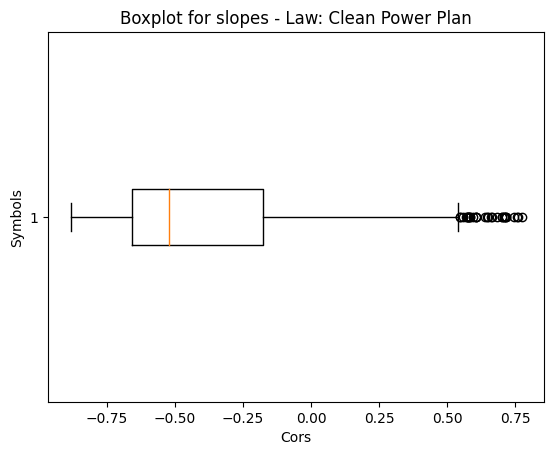

In [ ]:
### Request a boxplot Object for Clean Power Plan
# Clean Power Plan is at position 0 in the laws array (see chapter 5)
law = laws[0]

# Illustrate the spread of all cors accross all industries by using a boxplot
boxplot = boxplotForCorsByLaw(law, symbolsWithCors)
if boxplot is not False:
    boxplot.title(f"Boxplot for cors - Law: {law['name']}")
    boxplot.show()


#### Kommentar zum Boxplot
Die Verteilung zeigt, dass zu diesem Zeipunkt die Kurse der Unternehmen eher negativ verliefen. Es wäre also zu erwarten, dass die Histogramme mehrheitlich links gewichtet sind.

### 6.1.2 Histogram der Auswirkungen

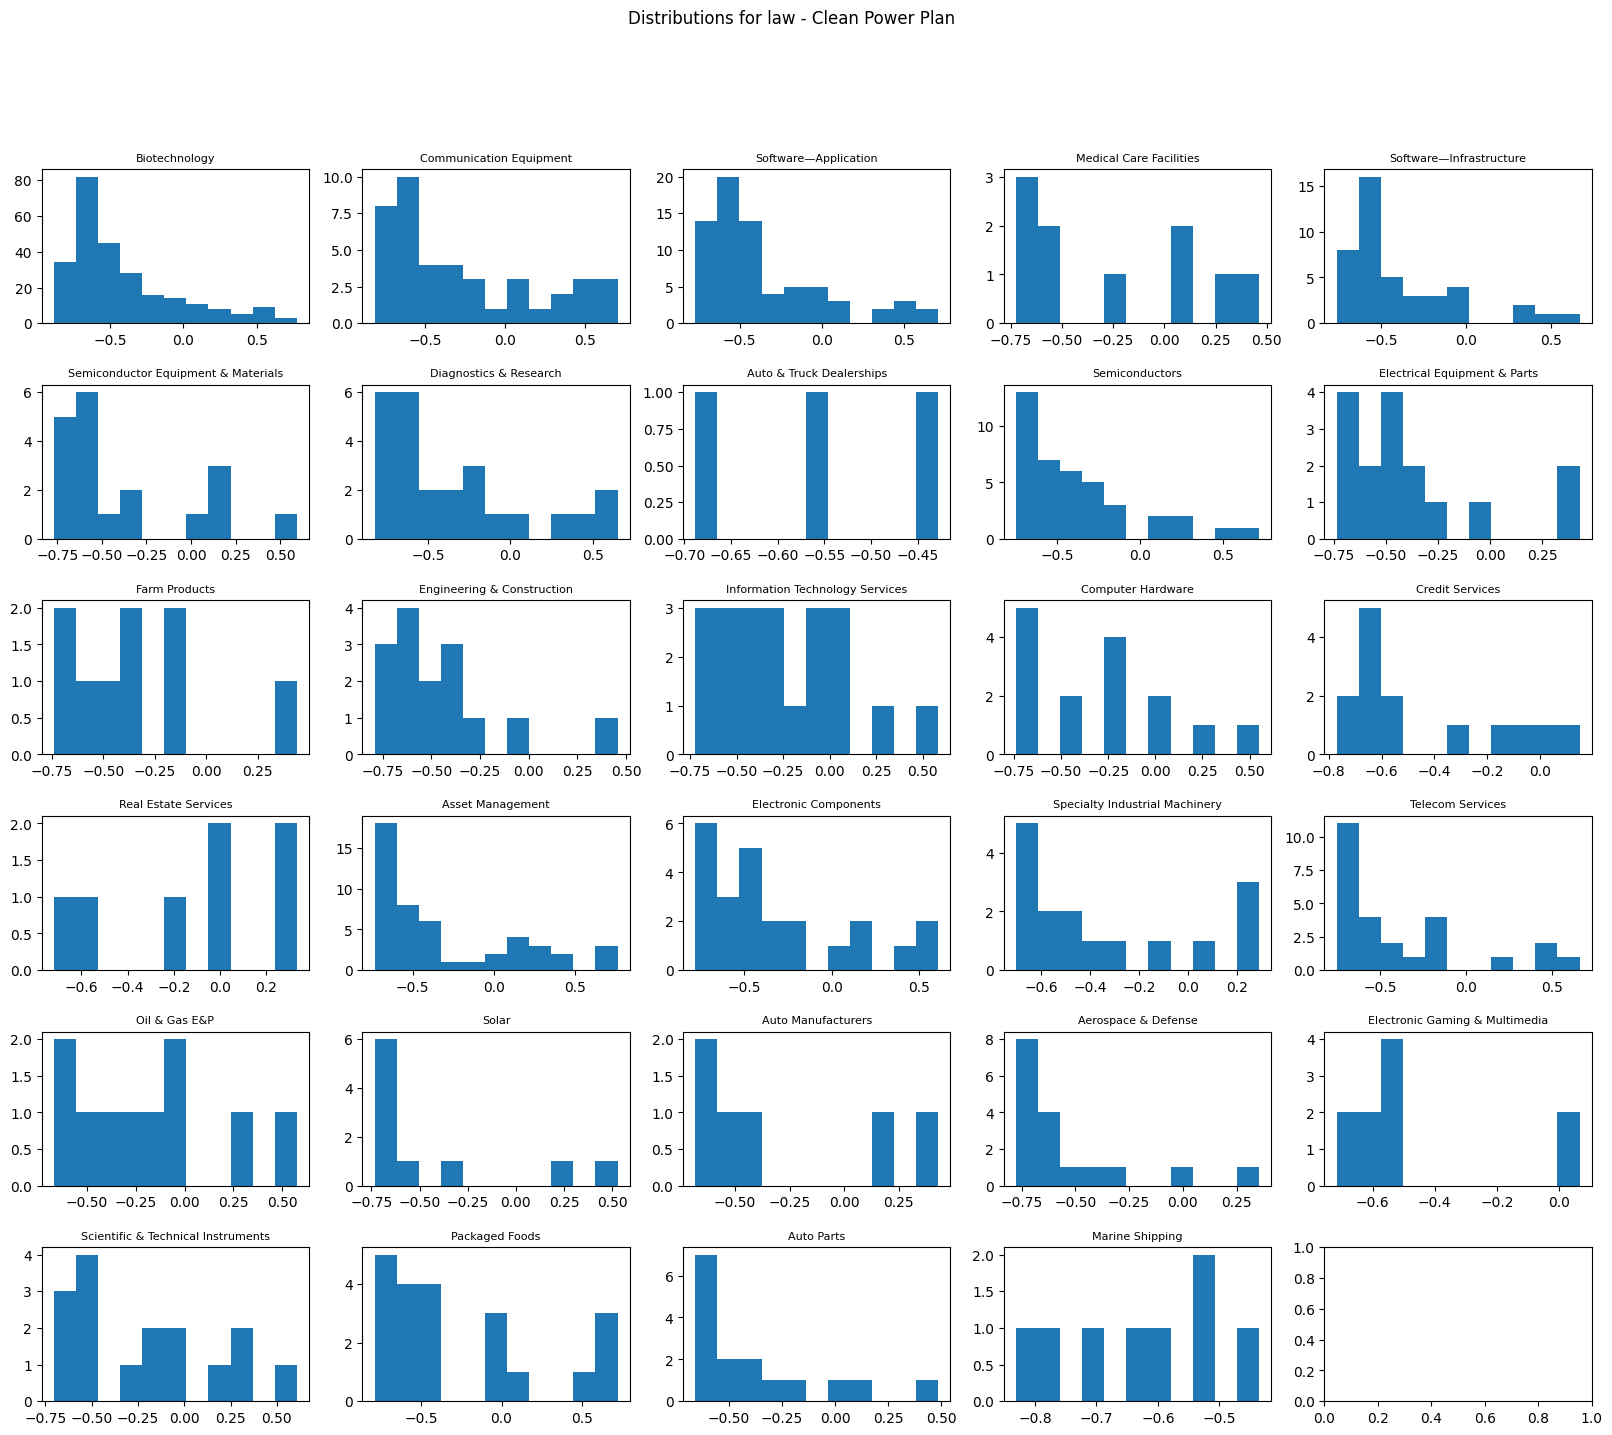

In [ ]:
### Group the symbols by industry
corsByIndustry = []
groupedSymbols = getGroupedSymbols(symbolsWithCors, 'industry')
for industry, symbols in groupedSymbols.items():
    # save data for the histogram matrix
    cors = getCorsDataByLaw(law, symbols)
    if len(cors) > 0:
        corsByIndustry.append({'industry': industry, 'cors': cors})

# get the combine histogram for all industries
histGrid = histogramGrid(corsByIndustry, law)
histGrid.show()

#### Kommentar zu den Histogrammen
Die Vermutung aus dem Boxplot hat sich bestätigt. Der Grossteil der untersuchten Industrien ist stärker bei den negativen Korrelationen angesiedelt, was auf einen sinkenden Aktienkurs hindeutet. Marine Shipping deckt hier das negativste Spektrum ab und war zu diesem Zeitpunkt besonders betroffen.

### 6.1.3 Ranking der Auswirkungen

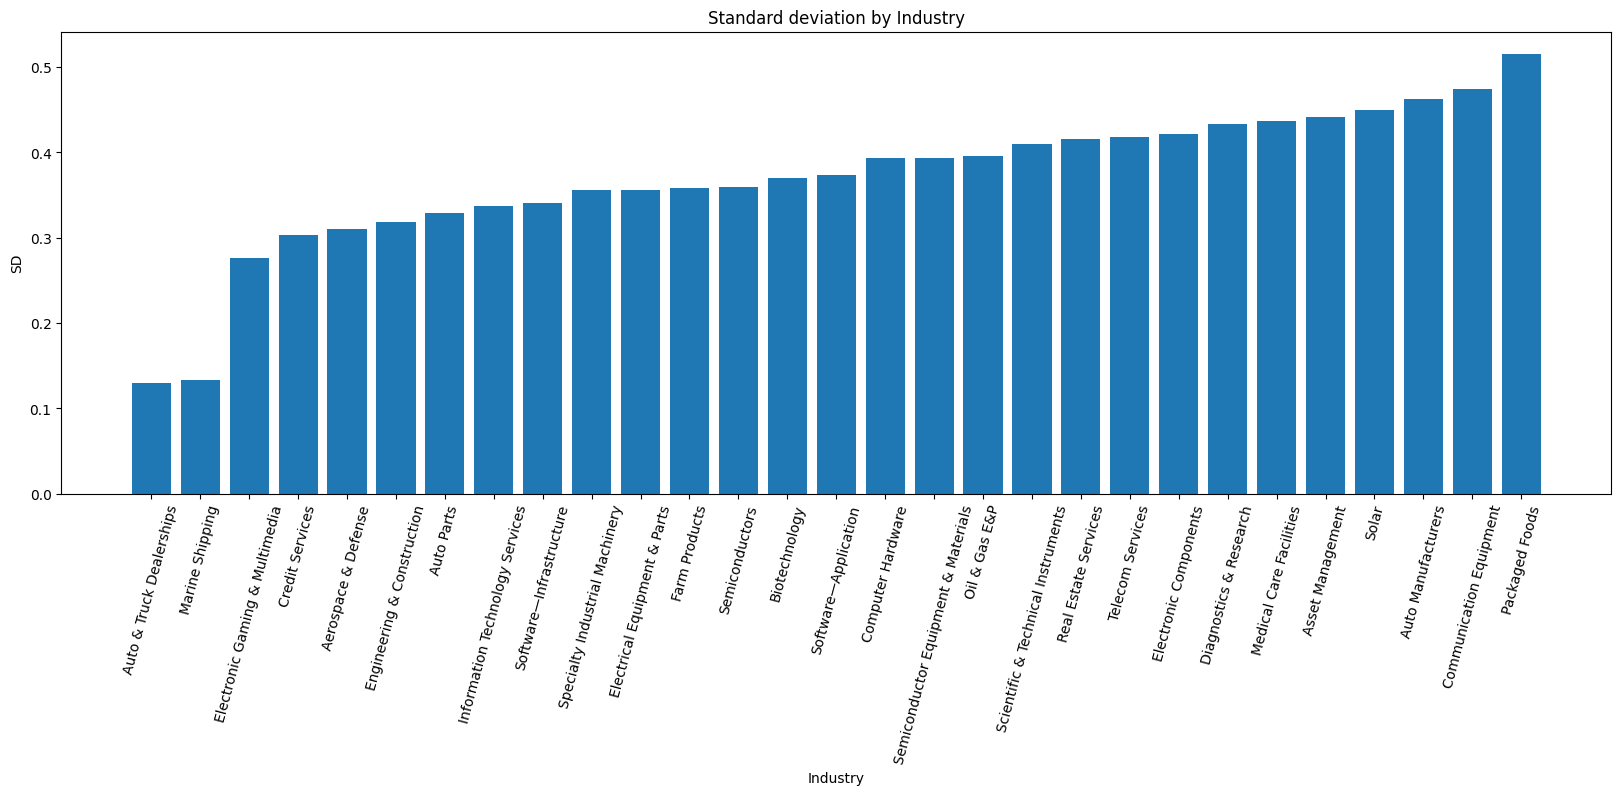

In [ ]:
### Create bar plot to compare the industries
sdsByIndustry = []
groupedSymbols = getGroupedSymbols(symbolsWithCors, 'industry')
for industry, symbols in groupedSymbols.items():
    # calculate the sd for the cors of the current industry and add it to the list
    sd = sdForCorsByLaw(law, symbols)
    if sd is not False:
        sdsByIndustry.append({'industry': industry, 'sd': sdForCorsByLaw(law, symbols)})

# sort the industries by standard deviation
sdsByIndustry.sort(key=lambda x: x['sd'])

# create a barplot
barplot = barplotForSdsByIndustry(sdsByIndustry)
barplot.show()

#### Kommentar zum Ranking
Sowohl Auto & Truck Dealerships als auch Marine Shipping haben eine geringe Abweichung in den Verläufen der Aktienkurse ihrer zugehörigen Unternehmen. Zusätzlich sind beide auch eher belastet gemäss ihrer Histogramme. Beide haben allerdings auch wenig zugrundliegende Daten, was eine Einordnung erschwert. Auf Basis dieser Aufbereitung deutet sich aber an, dass im Nachgang zum Clean Power Plan diese beiden Industrien mit einem negativeren Verlauf reagiert haben, als andere Branchen.

## 6.2 Affordable Clean Energy

### 6.2.1 Boxplot

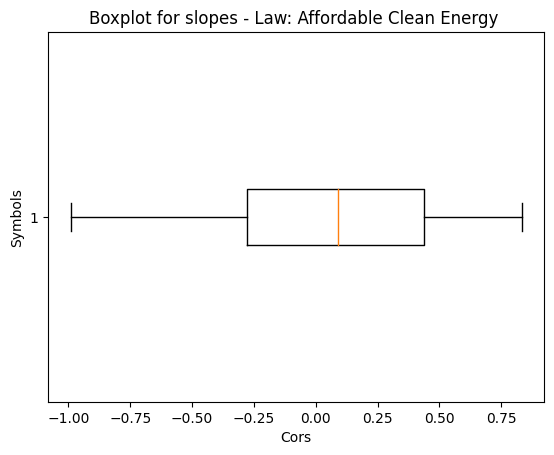

In [ ]:
### Request a boxplot Object for Affordable Clean Energy
# Affordable Clean Energy is at position 1 in the laws array (see chapter 5)
law = laws[1]

# Illustrate the spread of all cors accross all industries by using a boxplot
boxplot = boxplotForCorsByLaw(law, symbolsWithCors)
if boxplot is not False:
    boxplot.title(f"Boxplot for cors - Law: {law['name']}")
    boxplot.show()

#### Kommentar zum Boxplot
Im Nachgang zu diesem Gesetz scheinen die berücksichtigten Unternehmen mit Ausnahme einiger Ausreisser besser performed zu haben, als beim Clean Power Plan. Ein Grossteil der Verläufe liegt hier sogar im positiven Bereich.

### 6.2.2 Histogram der Auswirkungen

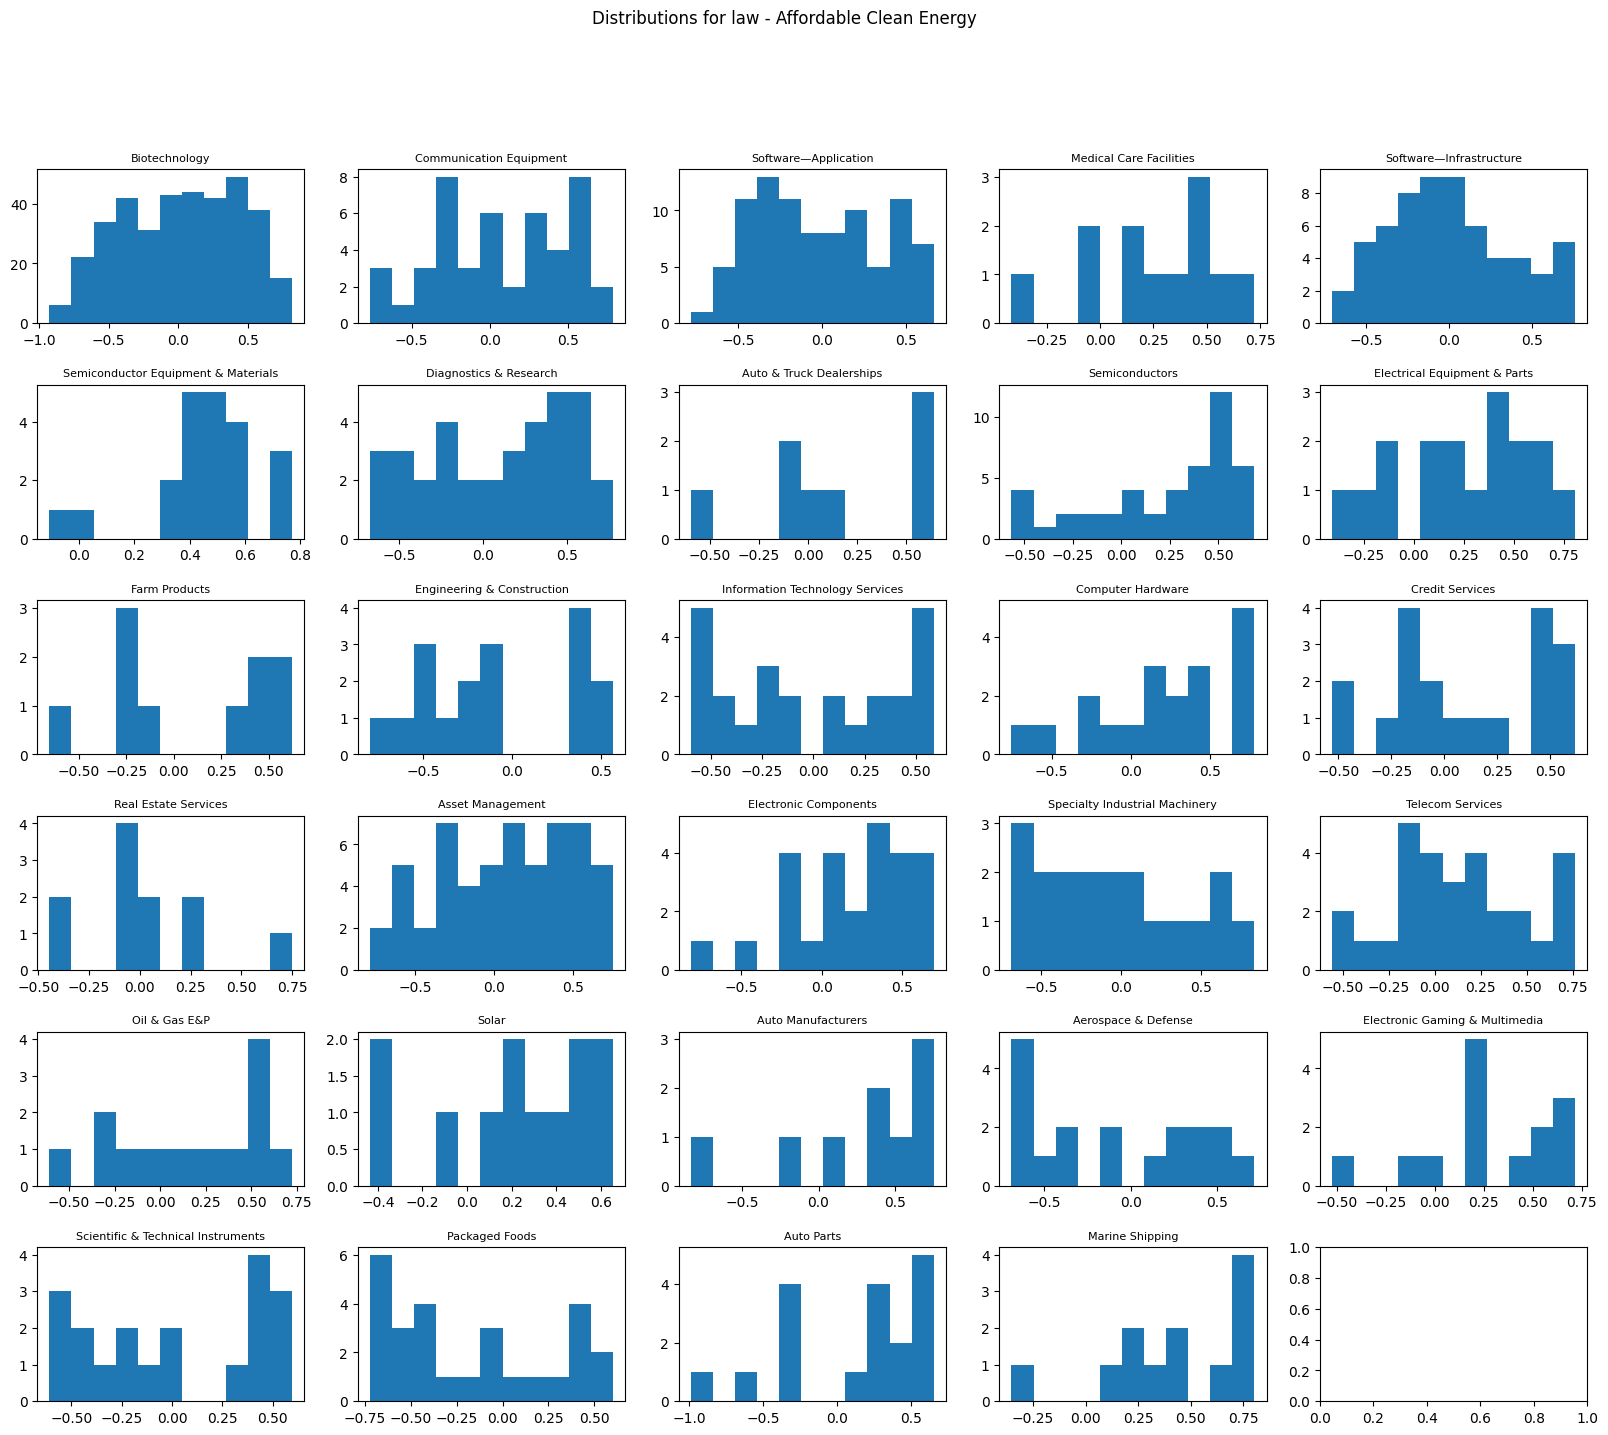

In [ ]:
### Group the symbols by industry
corsByIndustry = []
groupedSymbols = getGroupedSymbols(symbolsWithCors, 'industry')
for industry, symbols in groupedSymbols.items():
    # save data for the histogram matrix
    cors = getCorsDataByLaw(law, symbols)
    if len(cors) > 0:
        corsByIndustry.append({'industry': industry, 'cors': cors})

# get the combine histogram for all industries
histGrid = histogramGrid(corsByIndustry, law)
histGrid.show()

#### Kommentar zu den Histogrammen
Der Eindruck aus dem Boxplot zu Affordable Clean Energy bestätigt sich. Viele Industrien sind ausgeglichen in ihrem Histogram bis leicht rechtslastig. Generell scheint das Spektrum aber grösser, was darauf hindeutet, dass zu diesem Zeitpunkt die Unternehmen in den jeweiligen Industrien sehr unterschiedlich performed haben.

### 6.2.3 Ranking der Auswirkungen

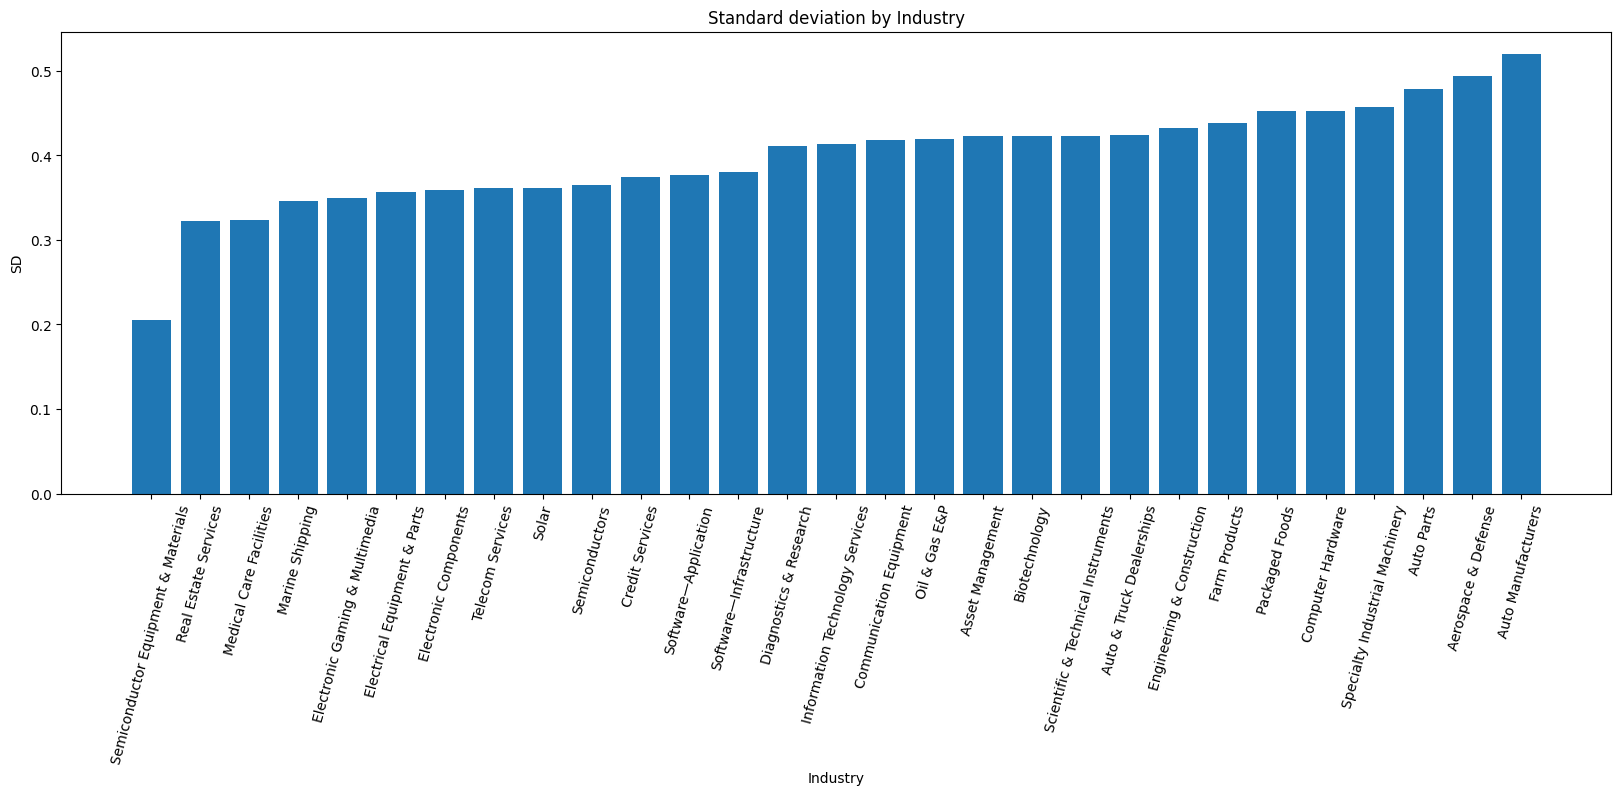

In [ ]:
### Create bar plot to compare the industries
sdsByIndustry = []
groupedSymbols = getGroupedSymbols(symbolsWithCors, 'industry')
for industry, symbols in groupedSymbols.items():
    # calculate the sd for the cors of the current industry and add it to the list
    sd = sdForCorsByLaw(law, symbols)
    if sd is not False:
        sdsByIndustry.append({'industry': industry, 'sd': sdForCorsByLaw(law, symbols)})

# sort the industries by standard deviation
sdsByIndustry.sort(key=lambda x: x['sd'])

# create a barplot
barplot = barplotForSdsByIndustry(sdsByIndustry)
barplot.show()

#### Kommentar zum Ranking
Wie erwartet sind die Abweichungen in den Korrelationskoeffizienten hier durchschnittlich höher als beim Clean Power Plan. Heraus sticht hier vor allem Semiconductor Equipment & Materials, wo die Abweichungen besonders gering sind. Ein Vergleich mit dem Histogram zeigt, dass die Industrie zum untersuchten Zeitpunkt insgesamt einen positiven Verlauf genommen hat. Da grundsätzlich alle Industrien eher positiv performed haben, lässt sich schwer sagen, ob und welchen Einfluss der Affordable Clean Energy Act hatte.

## 6.3 Paris Climate Agreement

### 6.3.1 Boxplot

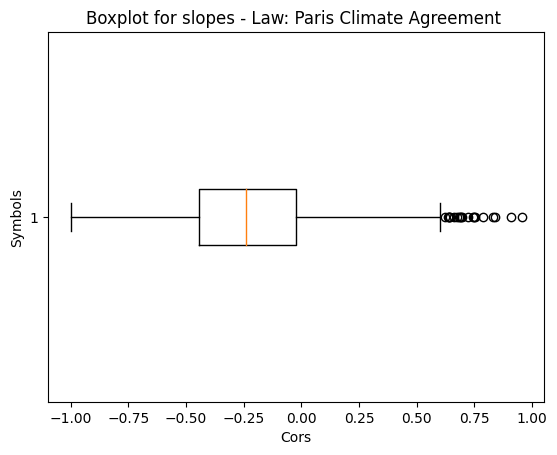

In [ ]:
### Request a boxplot Object for Paris Climate Agreement
# Paris Climate Agreement is at position 2 in the laws array (see chapter 5)
law = laws[2]

# Illustrate the spread of all cors accross all industries by using a boxplot
boxplot = boxplotForCorsByLaw(law, symbolsWithCors)
if boxplot is not False:
    boxplot.title(f"Boxplot for cors - Law: {law['name']}")
    boxplot.show()

#### Kommentar zum Boxplot
Zum Zeitpunkt des Wiederientritts in das Pariser Klimaabkommen der USA scheinen die untersuchten Unternehmen wieder grössere Problem gehabt zu haben. Dabei sollte aber bedacht werden, dass zu diesem Zeitpunkt auch noch die Corona-Pandemie vorherrschte. Ein Rückschluss auf den Wiedereintritt dürfte daher schwerfallen.

### 6.3.2 Histogram der Auswirkungen

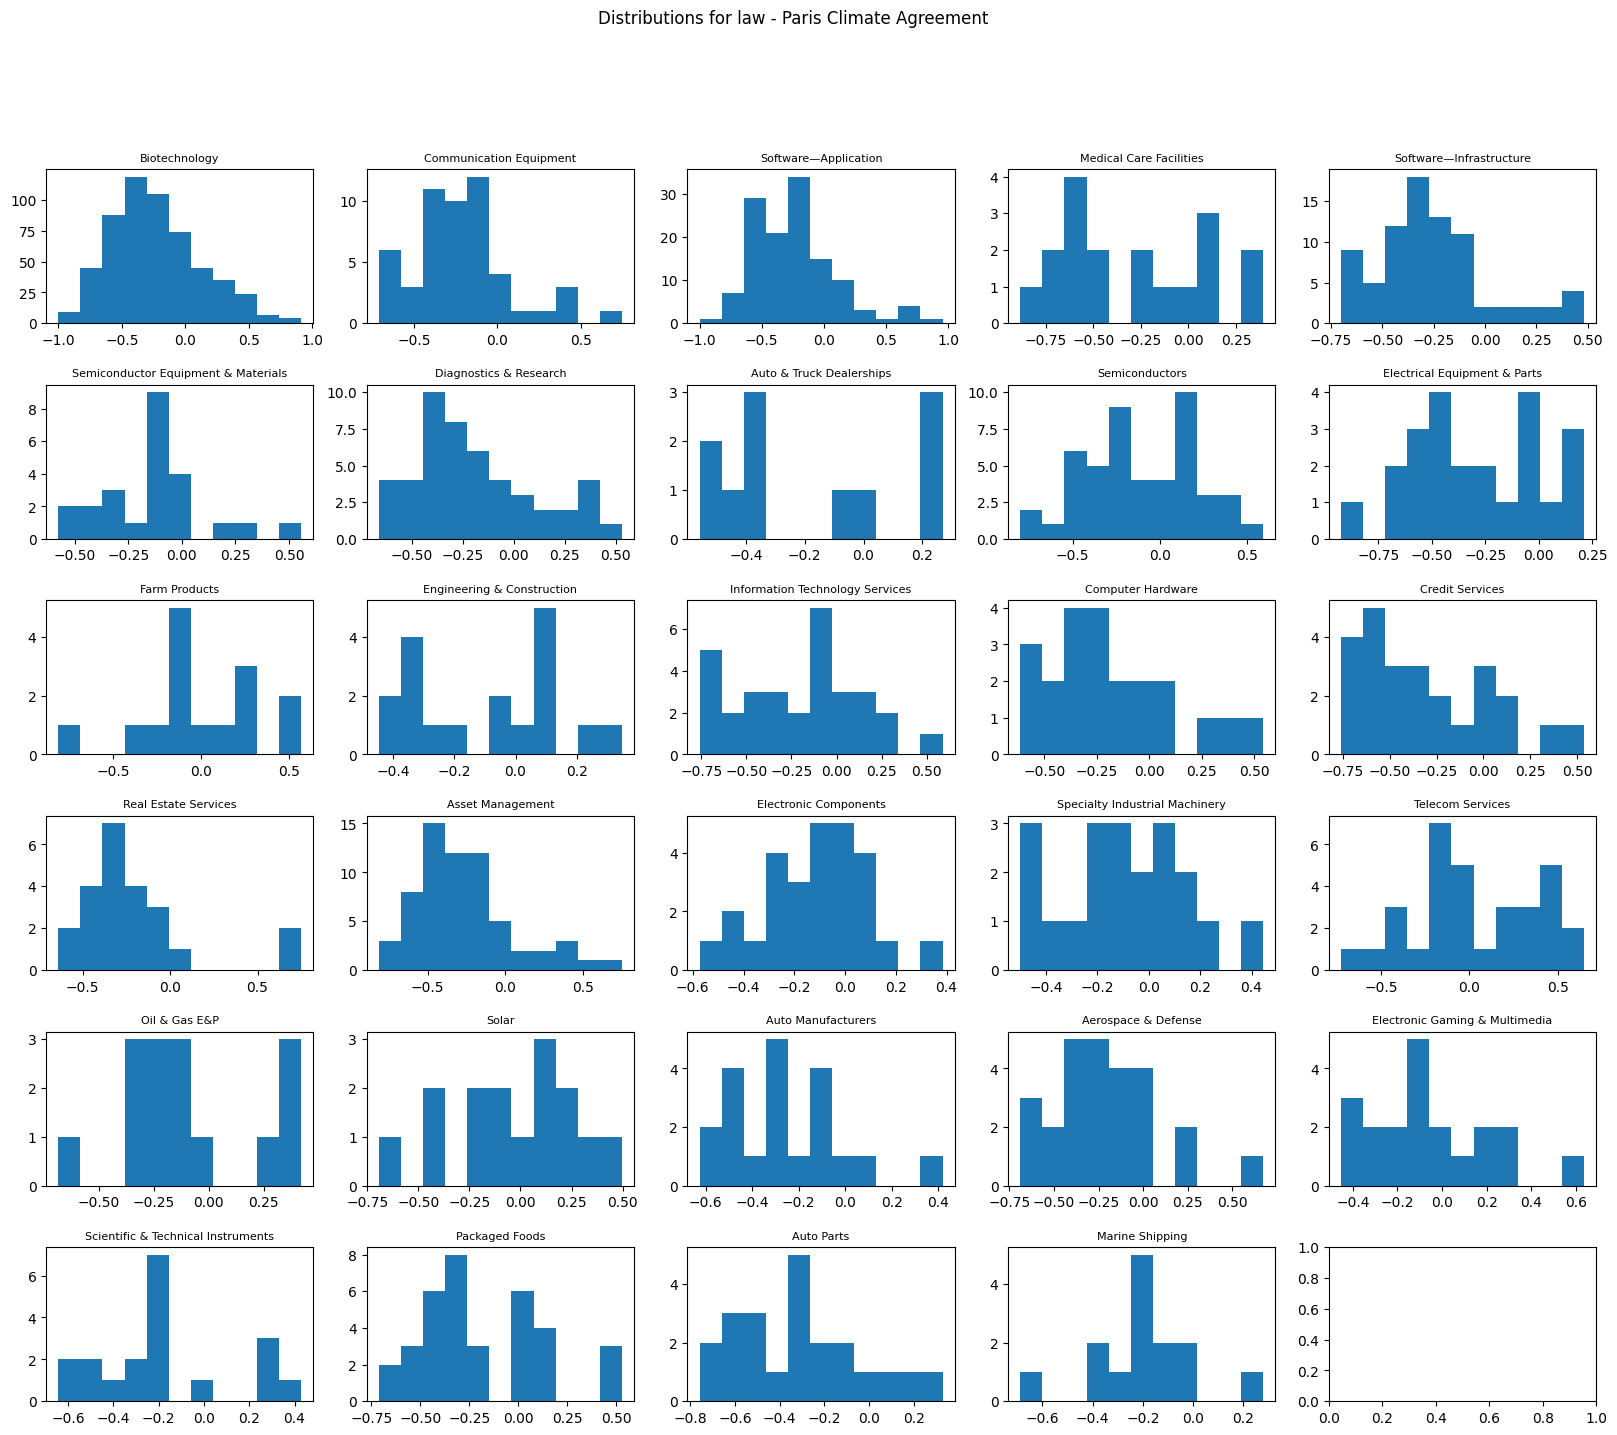

In [ ]:
### Group the symbols by industry
corsByIndustry = []
groupedSymbols = getGroupedSymbols(symbolsWithCors, 'industry')
for industry, symbols in groupedSymbols.items():
    # save data for the histogram matrix
    cors = getCorsDataByLaw(law, symbols)
    if len(cors) > 0:
        corsByIndustry.append({'industry': industry, 'cors': cors})

# get the combine histogram for all industries
histGrid = histogramGrid(corsByIndustry, law)
histGrid.show()

#### Kommentar zu den Histogrammen
In den Histogrammen zeigt sich das erwartete Bild ein Linkslastigkeit im negativen Bereich.

### 6.3.3 Ranking der Auswirkungen

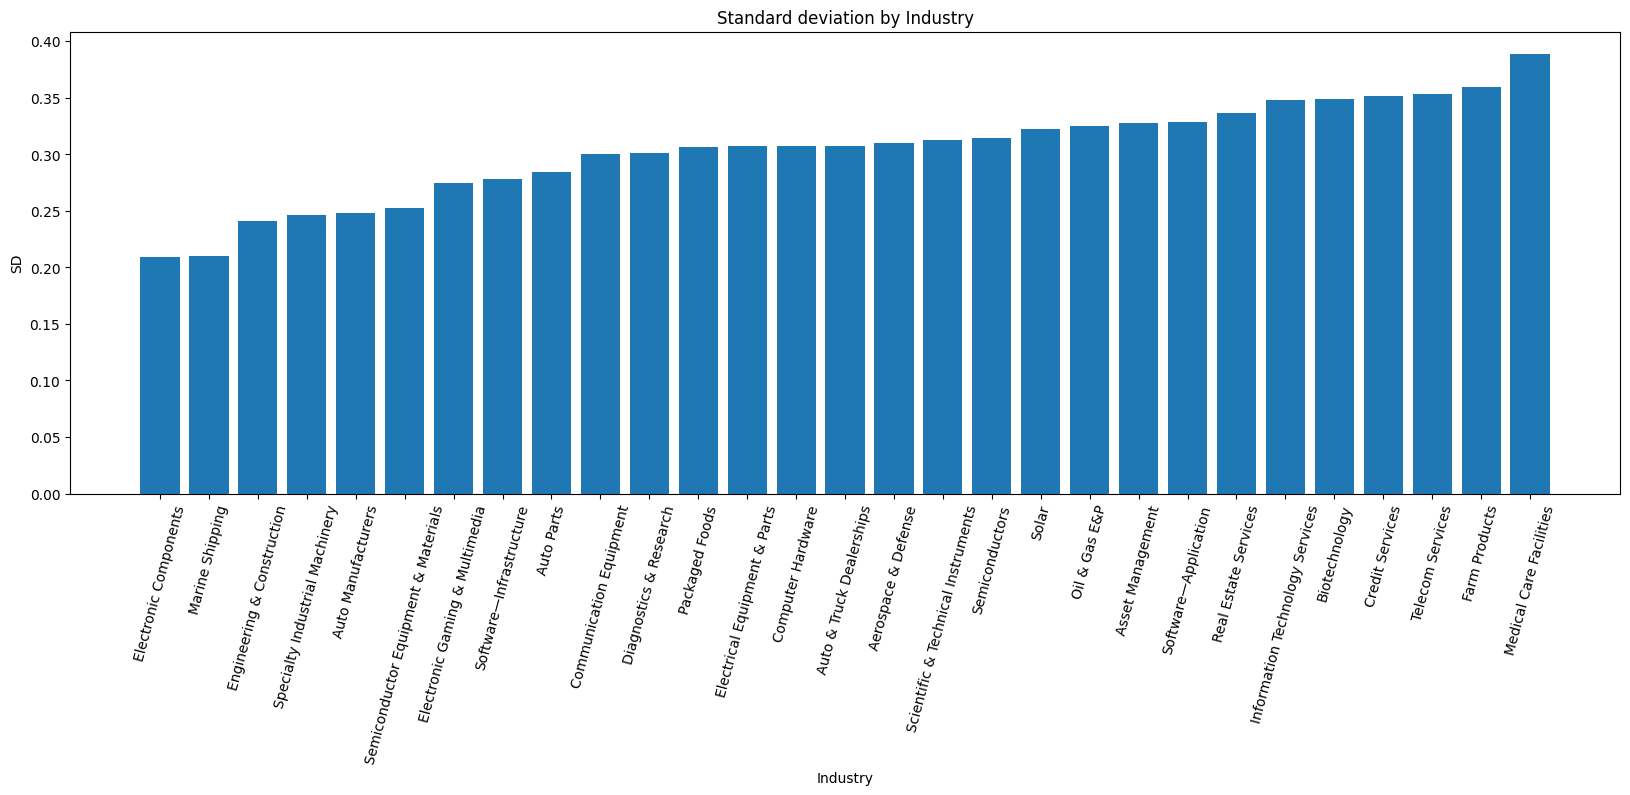

In [ ]:
### Create bar plot to compare the industries
sdsByIndustry = []
groupedSymbols = getGroupedSymbols(symbolsWithCors, 'industry')
for industry, symbols in groupedSymbols.items():
    # calculate the sd for the cors of the current industry and add it to the list
    sd = sdForCorsByLaw(law, symbols)
    if sd is not False:
        sdsByIndustry.append({'industry': industry, 'sd': sdForCorsByLaw(law, symbols)})

# sort the industries by standard deviation
sdsByIndustry.sort(key=lambda x: x['sd'])

# create a barplot
barplot = barplotForSdsByIndustry(sdsByIndustry)
barplot.show()

#### Kommentar zum Ranking
Für den Wiedereintritt in das Pariser Klimmaabkommen stehen die Branchen erwartet nah beieinander. Die Abweichungen sind hier am geringsten gegenüber den anderen Gesetzen. Der Grund liegt hierbei aber vermutlich stärker an der allgemein angespannten wirtschaftlichen Lage und weniger am Klimaabkommen selbst.

## 6.4 Inflation Reduction Act

### 6.4.1 Boxplot

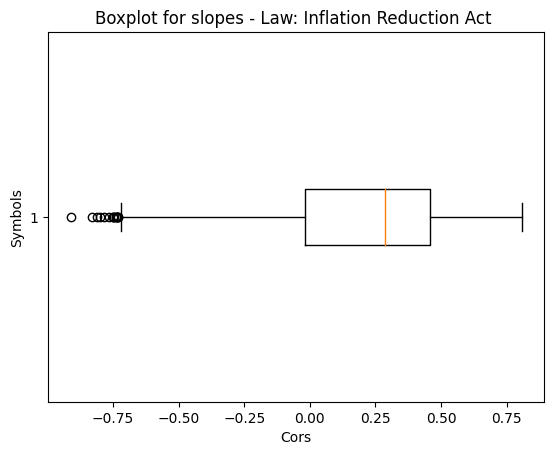

In [ ]:
### Request a boxplot Object for Inflation Reduction Act
# Inflation Reduction Act is at position 3 in the laws array (see chapter 5)
law = laws[3]

# Illustrate the spread of all cors accross all industries by using a boxplot
boxplot = boxplotForCorsByLaw(law, symbolsWithCors)
if boxplot is not False:
    boxplot.title(f"Boxplot for cors - Law: {law['name']}")
    boxplot.show()

#### Kommentar zum Boxplot
Der Boxplot zum Inflation Reduction Act ist erstaunlich positiv gewichtet. Erwartet wäre aufgrund des Angriffskriegs durch Russland auf die Ukraine ein ähnlich verwaschenes Bild wie bei der Corona-Krise. Es gibt aber auch starke negative Ausreisser.

### 6.4.2 Histogram der Auswirkungen

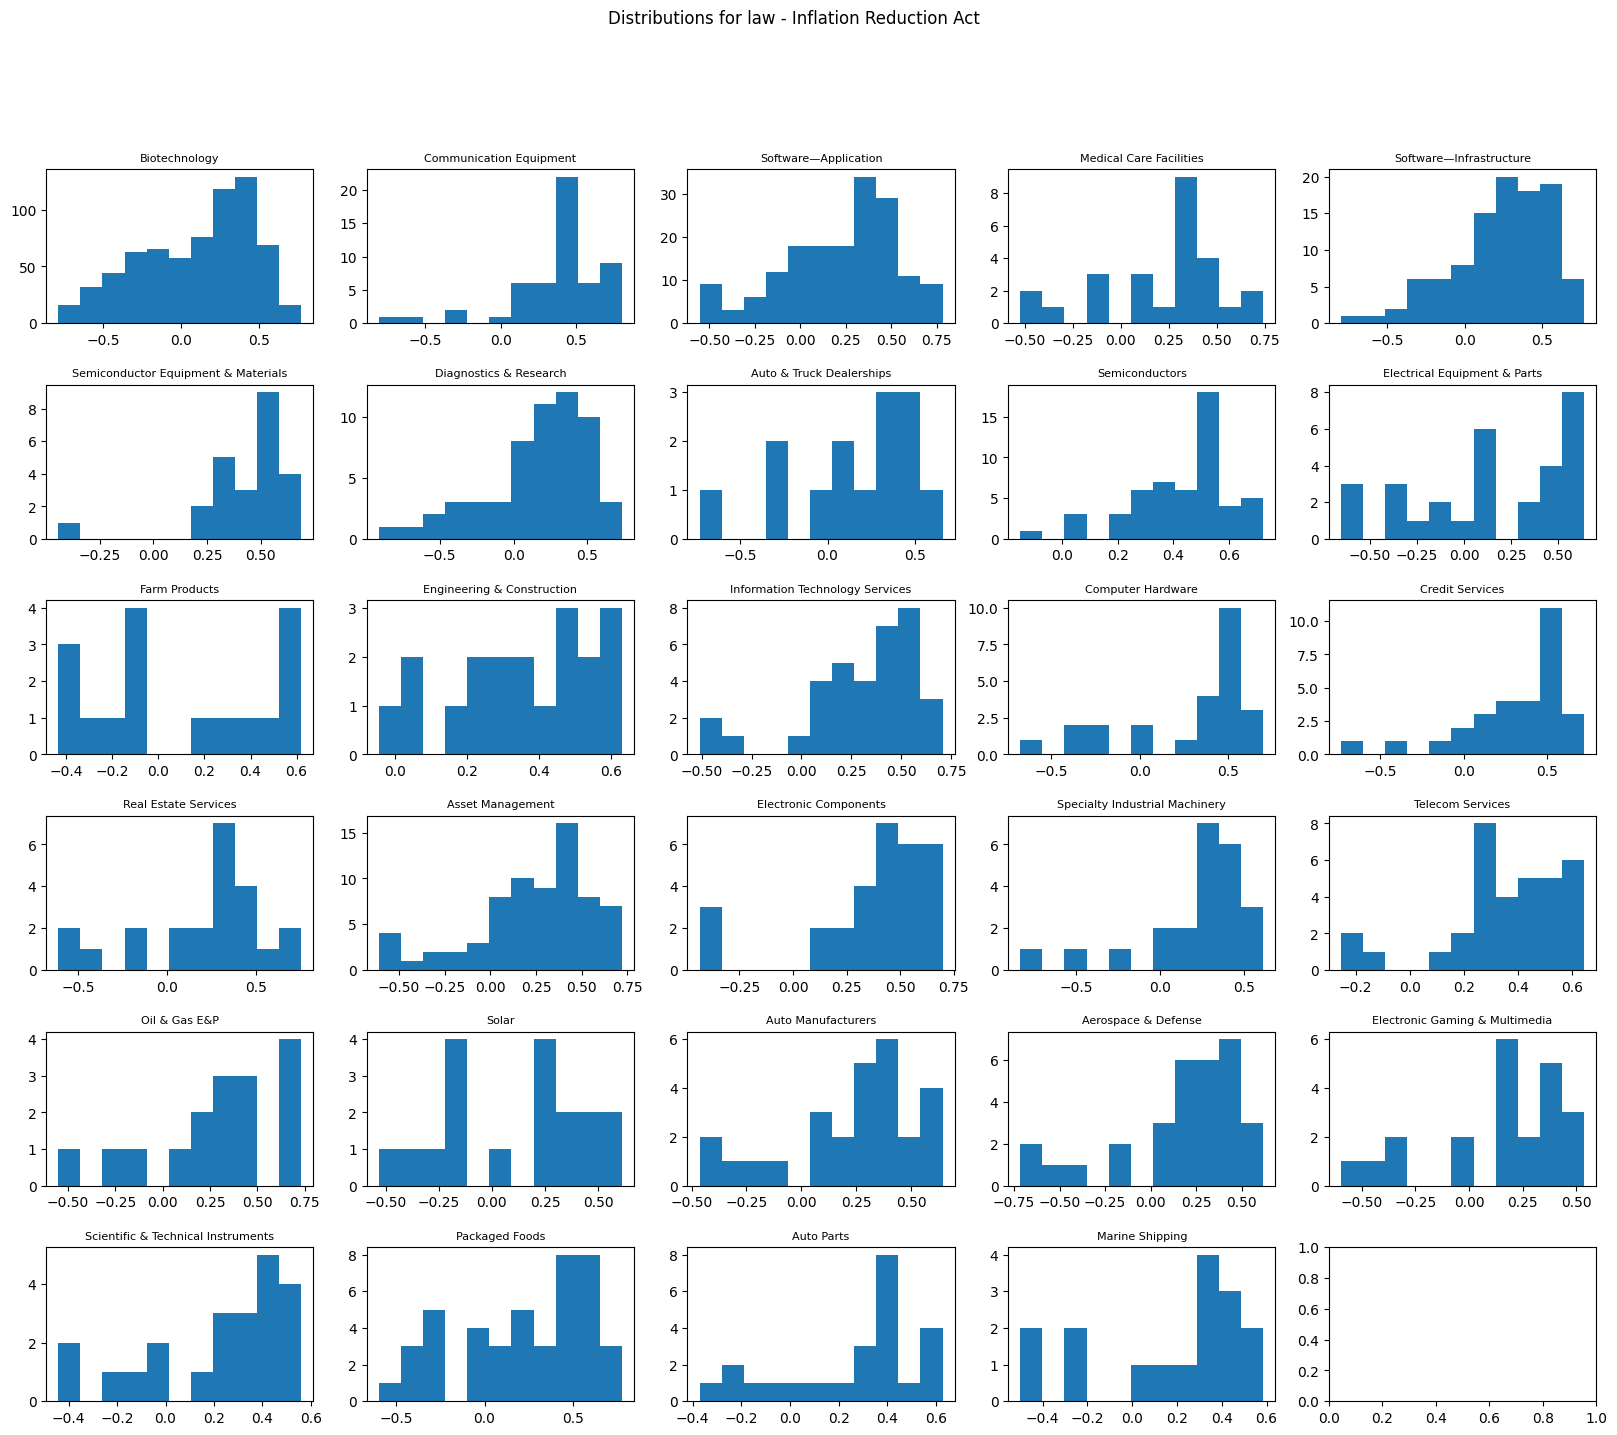

In [ ]:
### Group the symbols by industry
corsByIndustry = []
groupedSymbols = getGroupedSymbols(symbolsWithCors, 'industry')
for industry, symbols in groupedSymbols.items():
    # save data for the histogram matrix
    cors = getCorsDataByLaw(law, symbols)
    if len(cors) > 0:
        corsByIndustry.append({'industry': industry, 'cors': cors})

# get the combine histogram for all industries
histGrid = histogramGrid(corsByIndustry, law)
histGrid.show()

#### Kommentar zu den Historgrammen
Die erwatete Rechtslastigkeit spiegelt sich in den Histogrammen wider. Interessant ist die Rechtslastigkeit von Öl und Gas gegenüber Solaranlagen. Dies könnte mit der Verknappung durch einen Importstopp der Güter aus Russland zusammenhängen. Insgesamt hat der Inflation Reduction Act aber keine feststellbare negative Auswirkungen auf Branchen wie Fossile Brennstoffe oder Individual- und Güterverkehr gehabt.

### 6.4.3 Ranking der Auswirkungen

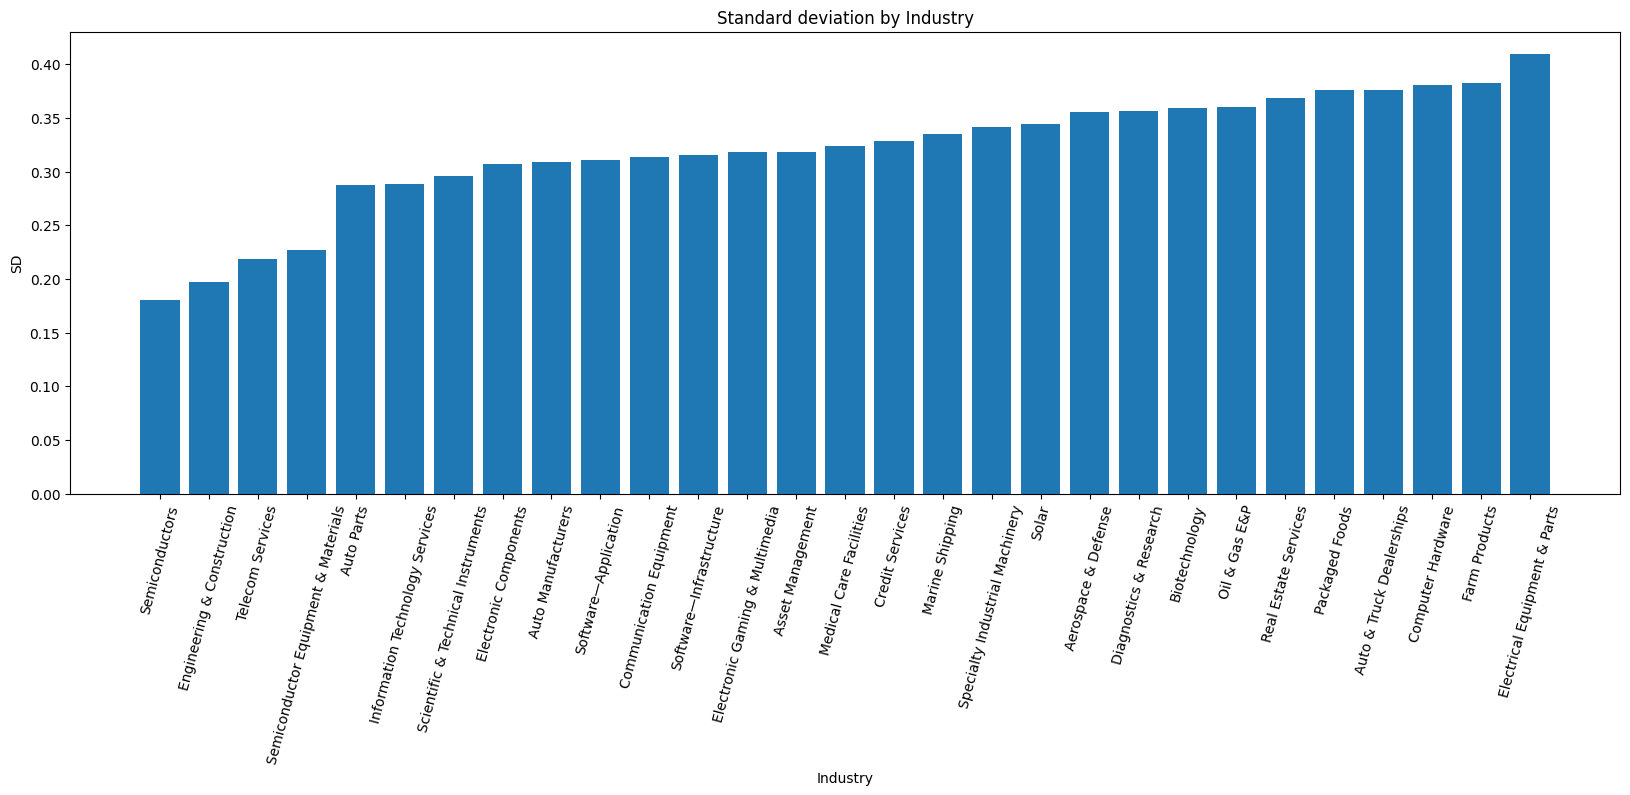

In [ ]:
### Create bar plot to compare the industries
sdsByIndustry = []
groupedSymbols = getGroupedSymbols(symbolsWithCors, 'industry')
for industry, symbols in groupedSymbols.items():
    # calculate the sd for the cors of the current industry and add it to the list
    sd = sdForCorsByLaw(law, symbols)
    if sd is not False:
        sdsByIndustry.append({'industry': industry, 'sd': sdForCorsByLaw(law, symbols)})

# sort the industries by standard deviation
sdsByIndustry.sort(key=lambda x: x['sd'])

# create a barplot
barplot = barplotForSdsByIndustry(sdsByIndustry)
barplot.show()

#### Kommentar zum Ranking
Hier liegen die Werte wieder näher beieinander, diesmal im positiven Bereich. Dies spricht zwar für die angewandte Methodik in der Einordnung, jedoch lässt es wenig Aufschluss über den Einfluss des Gesetzes selbst zu.

# 7. Fazit
Das angewandte Vorgehen war sehr spannend. Es war herausfordernd die Menge an Daten zu filtern und sinnvoll Prioritäten zu setzen. Die Arbeit mit Python hat dabei viele Erkenntnisse geliefert.

Bezogen auf die Aggregierung kann für zukünftige Projekte viel mitgenommen werden. Gerade das gruppieren und filtern konnte eine Perspektive auf das Thema Datenhandhabung und -erhebung vermitteln.

In der Analyse hat sich gezeigt, dass die schwankende Datenmenge zu den Unternehmen Aussagen schwierig macht. Zwar gibt es viele Daten, aber nicht alle Unternehmen aus den vielleicht besonders betroffenen Branchen sind börsenkotiert. Daher tauchen sie in den Erhebungen nicht auf.

Aufbauend auf den Überlegungen dieser Analyse könnten Branchen/Industrien stärker zusammengefasst werden. Dies würde eine breitere Abstützung durch die Unternehmensdaten ermöglichen und die Analyseergebnisse verbessern. Das angewandte Vorgehen für die Einordnung und Visualisierung war sehr hilfreich, da ein Eindruck über den Stand pro Industrie vermittelt werden konnte. Problematisch ist aber, dass der direkte Einfluss der klimatischen Aspekte der Gesetze schwer eingegrenzt werden kann. Die Lage der Unternehmen war zu den untersuchten Zeitpunkten zu stark von anderen geopolitischen oder wirtschaftlichen Themen geprägt, um hier den Effekt einordnen zu können. Auch ohne diese Faktoren haben die Gesetze nicht nur einen reinen Fokus auf Umweltthemen, sondern auch anderes. Dies erschwert ebenfalls einen Rückschluss auf die klimatischen Aspekte.

# -- Anhang / Notizen ---

Der nachfolgende Code kann für die manuelle Überprüfung und Visualisierung der Berechnung der Trendlinien und der Visualisierung auf dem Aktienkurs verwendet werden. Im Code sind die anpassbaren Stellen per Kommentar beschrieben.

[*********************100%***********************]  1 of 1 completed
slope of trend line: 58.44039122389639


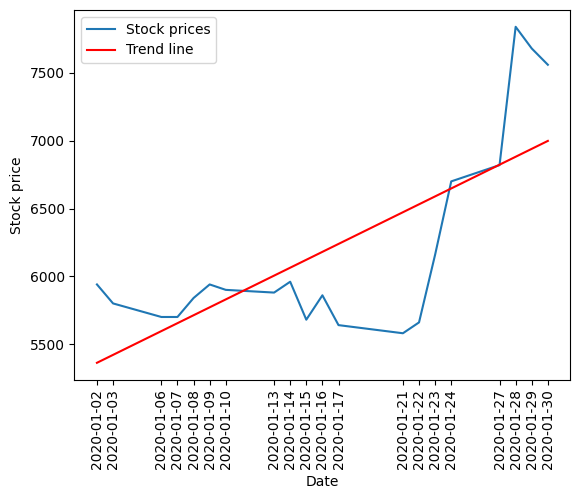

In [ ]:
### Example for querying a symbol, calculating the slope for a given time and visually representing it
### Used to manually verify the calculated slopes and the visual representation
import yfinance as yf
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
import matplotlib.dates as mdates
import sys

# Editable: Choose smybol, startDate and endDate (use "YYYY-MM-DD" format from verifiedSymbolsWithSlopes.json)
symbol = "AGRX"
startDate = "2020-01-01"
endDate = "2020-01-31"


### DO NOT EDIT after this point
# get data
startDate = datetime.strptime(startDate, '%Y-%m-%d')
endDate = datetime.strptime(endDate, '%Y-%m-%d')
data = yf.download(symbol, start=startDate, end=endDate)

# only use closing value
close_prices = data['Close']
dates = close_prices.index

# calculate trend line
days = [date.day for date in dates]
z = np.polyfit(days, close_prices, 1)
p = np.poly1d(z)

# calculate slope of trend line
slope = z[0]
print("slope of trend line:", slope)

# create line chart
fig, ax = plt.subplots()
ax.plot(dates, close_prices, label='Stock prices')
ax.plot(dates, p(days), color='red', label='Trend line')

# add axis titles
ax.set_xlabel('Date')
ax.set_ylabel('Stock price')

# Format and rotate Axis titles
plt.xticks(dates, rotation=90)

# show legend
ax.legend()

# draw plot
plt.show()


In [ ]:
### Archived code needed for testing, can be ignored

from ftplib import FTP
from io import BytesIO
import random
import yfinance as yf
# Testing automated retrieving of market data

#s1 Create a connection to Nasdaq FTP server to retrieve symbols
host = 'ftp.nasdaqtrader.com'
path = 'SymbolDirectory'
symbolFile = 'nasdaqlisted.txt'

reader = BytesIO()

ftp = FTP(host)
ftp.login()
ftp.cwd(path)
ftp.retrbinary('RETR ' + symbolFile, reader.write)

symbols = reader.getvalue().decode('ascii').split('\r\n')
symbols.pop(0)
for index, symbol in enumerate(symbols):
    symbols[index] = symbols[index].split('|')[0]

#s2 Choose 5 random symbols
querySymbols = []
for i in range(5):
  randomIndex = random.randint(0, len(symbols) - 1)
  querySymbols.append(symbols[randomIndex])

#s3 Fetch market data for the random symbols
start = '2023-01-01'
end = '2023-01-31'
querySymbolData = dict()
for symbol in querySymbols:
  querySymbolData[symbol] = yf.download(symbol, start = start, end = end, progress = False)

print(querySymbolData)









{'EWCZ':                  Open       High        Low      Close  Adj Close  Volume
Date                                                                     
2023-01-03  12.620000  13.040000  12.565000  13.000000  13.000000  313400
2023-01-04  13.130000  13.760000  13.020000  13.750000  13.750000  265600
2023-01-05  13.500000  13.740000  13.250000  13.570000  13.570000  165200
2023-01-06  13.580000  13.730000  13.485000  13.550000  13.550000  207000
2023-01-09  13.740000  16.080000  13.740000  15.660000  15.660000  732600
2023-01-10  16.059999  16.540001  15.450000  15.740000  15.740000  585700
2023-01-11  15.890000  16.260000  15.739000  15.930000  15.930000  202500
2023-01-12  16.000000  16.730000  15.490000  16.450001  16.450001  197400
2023-01-13  16.299999  16.740000  16.120001  16.620001  16.620001  169100
2023-01-17  16.650000  16.910000  16.150000  16.799999  16.799999  294900
2023-01-18  17.020000  17.209999  16.805000  16.959999  16.959999  451500
2023-01-19  16.840000  17.155